In [1]:
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)

Loading required package: ggpubr

Loading required package: grid

Loading required package: magrittr

Loading required package: checkmate

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading 'meta' package (version 6.2-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs


Attaching package: ‘epitools’


The following object is masked from ‘package:survival’:

    ratetable




In [2]:
All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

In [3]:
datasets_mu = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_mutation_with_therapy.rds")

In [4]:
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)
datasets_overview = datasets_overview[names(All),]

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(All[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(All[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(All[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

In [5]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1

In [6]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_overview$Cohort_name)

dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

In [7]:
ref_cohort_cal_TMB = function(dataset,cutoff_ratio = 0.5){
  

    tmp_data = All[[dataset]]
    cutoff = quantile(na.omit(tmp_data[,"TMB"]),probs = 1-cutoff_ratio,na.rm = T)
    low = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) < cutoff]
    high = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) >= cutoff]
  
  return(list("low"=low,"high"=high,"cutoff"=cutoff))
  
}

ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


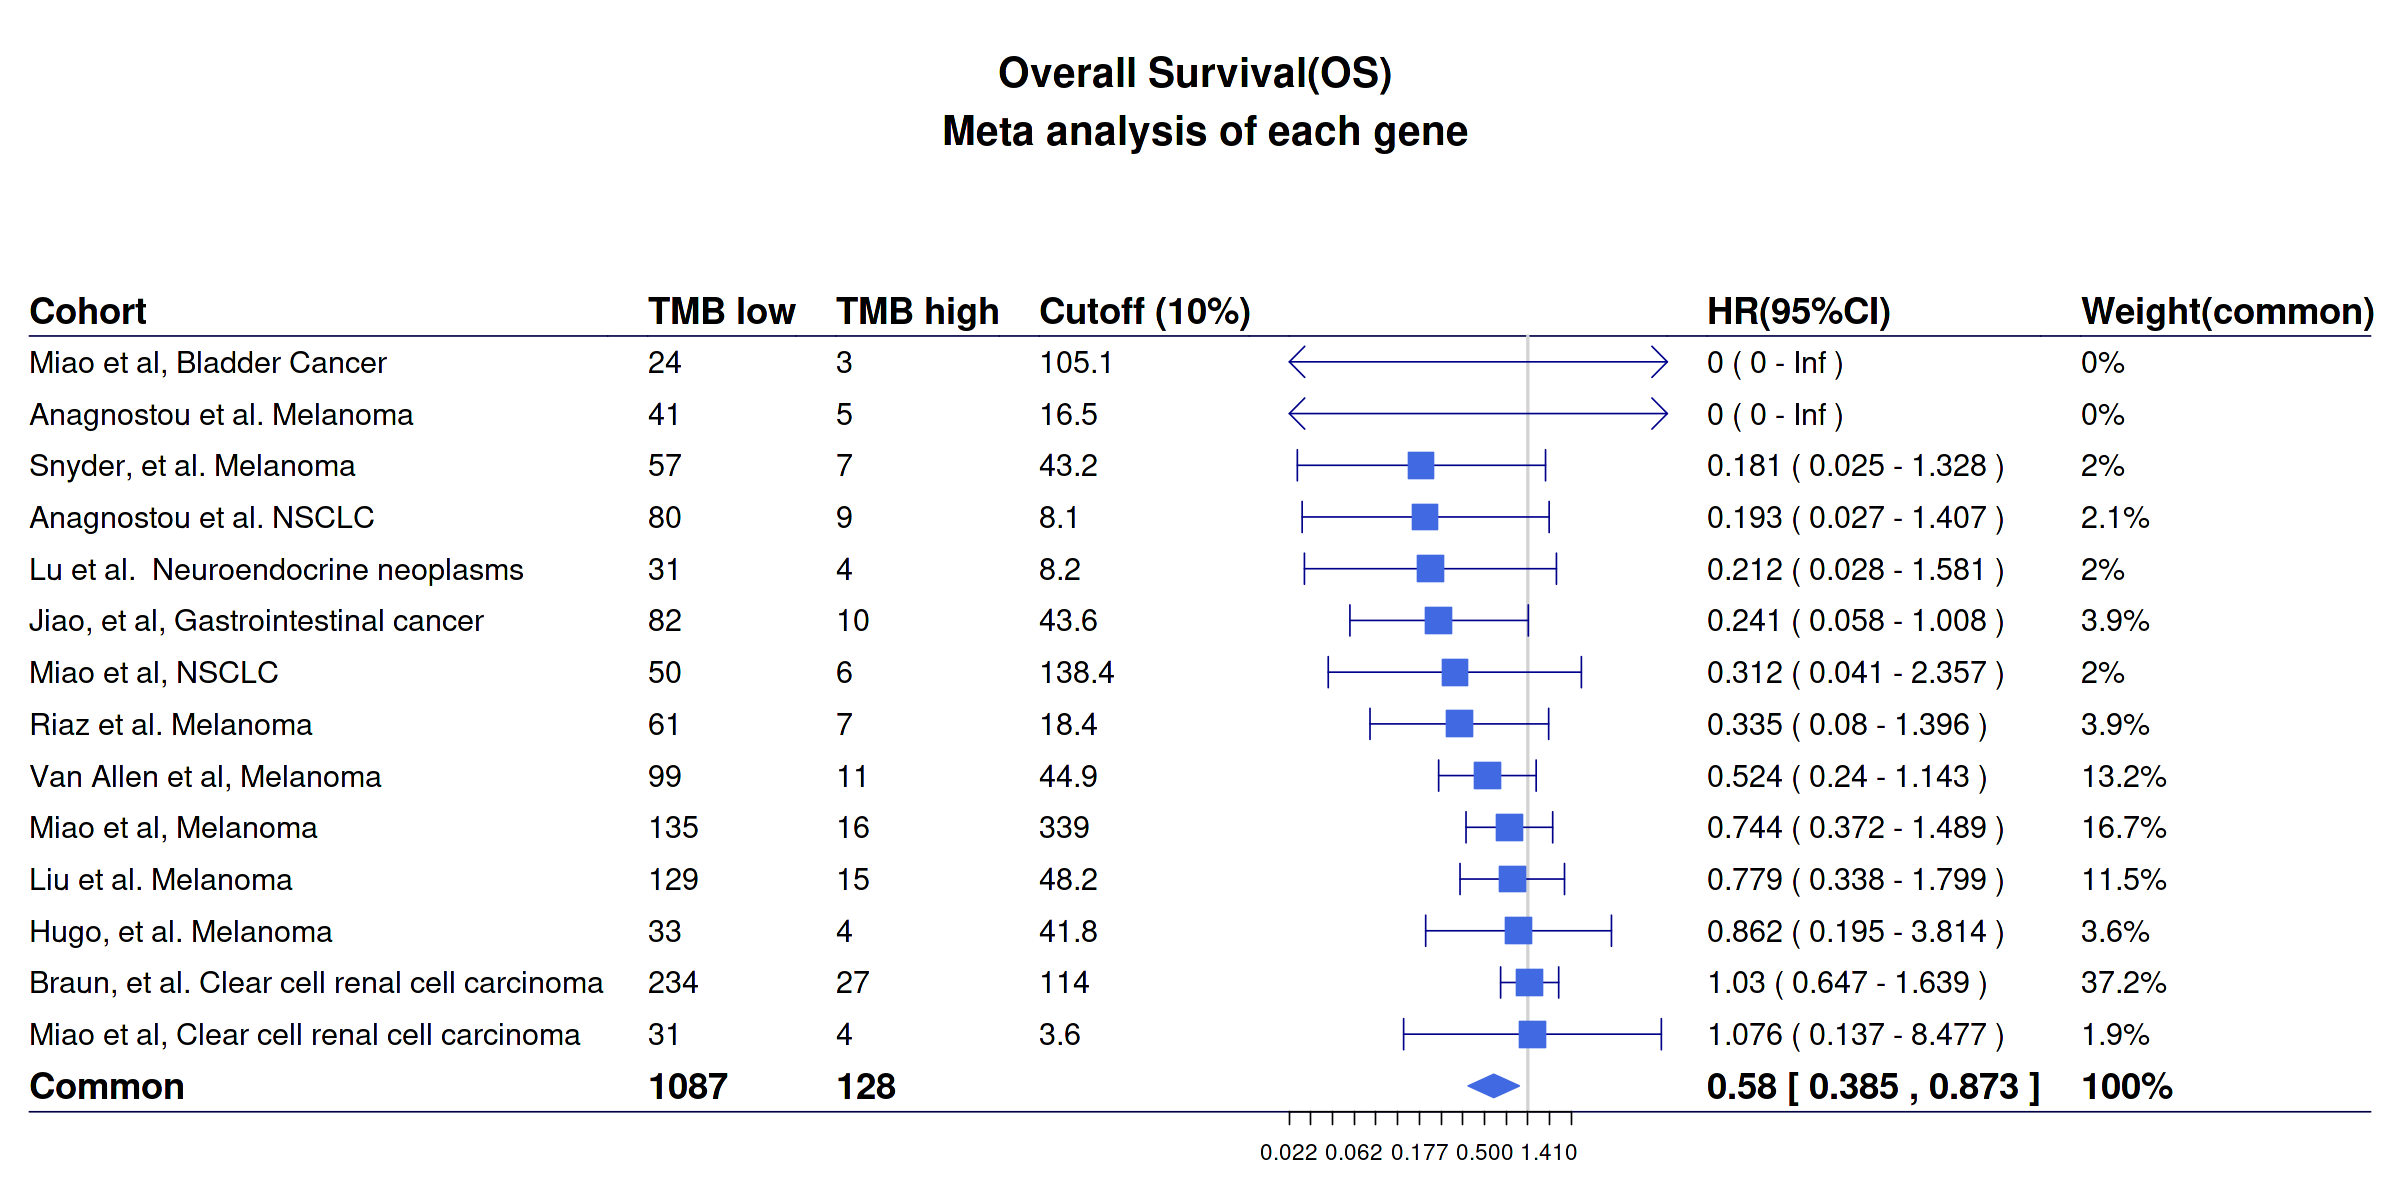

In [8]:
library(forestplot)
cohort = vector()
cutoff = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.1)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))
      
    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }

    
    
    
  }
}

ord = order(HR_mean)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"TMB low",low[ord],sum(low),sum(low)),
                  c(NA,"TMB high",high[ord],sum(high),sum(high)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (10%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [9]:
TMB_OS_tabletext.1 = TMB_OS_tabletext
TMB_OS_cochrane_from_rmeta.1 = TMB_OS_cochrane_from_rmeta

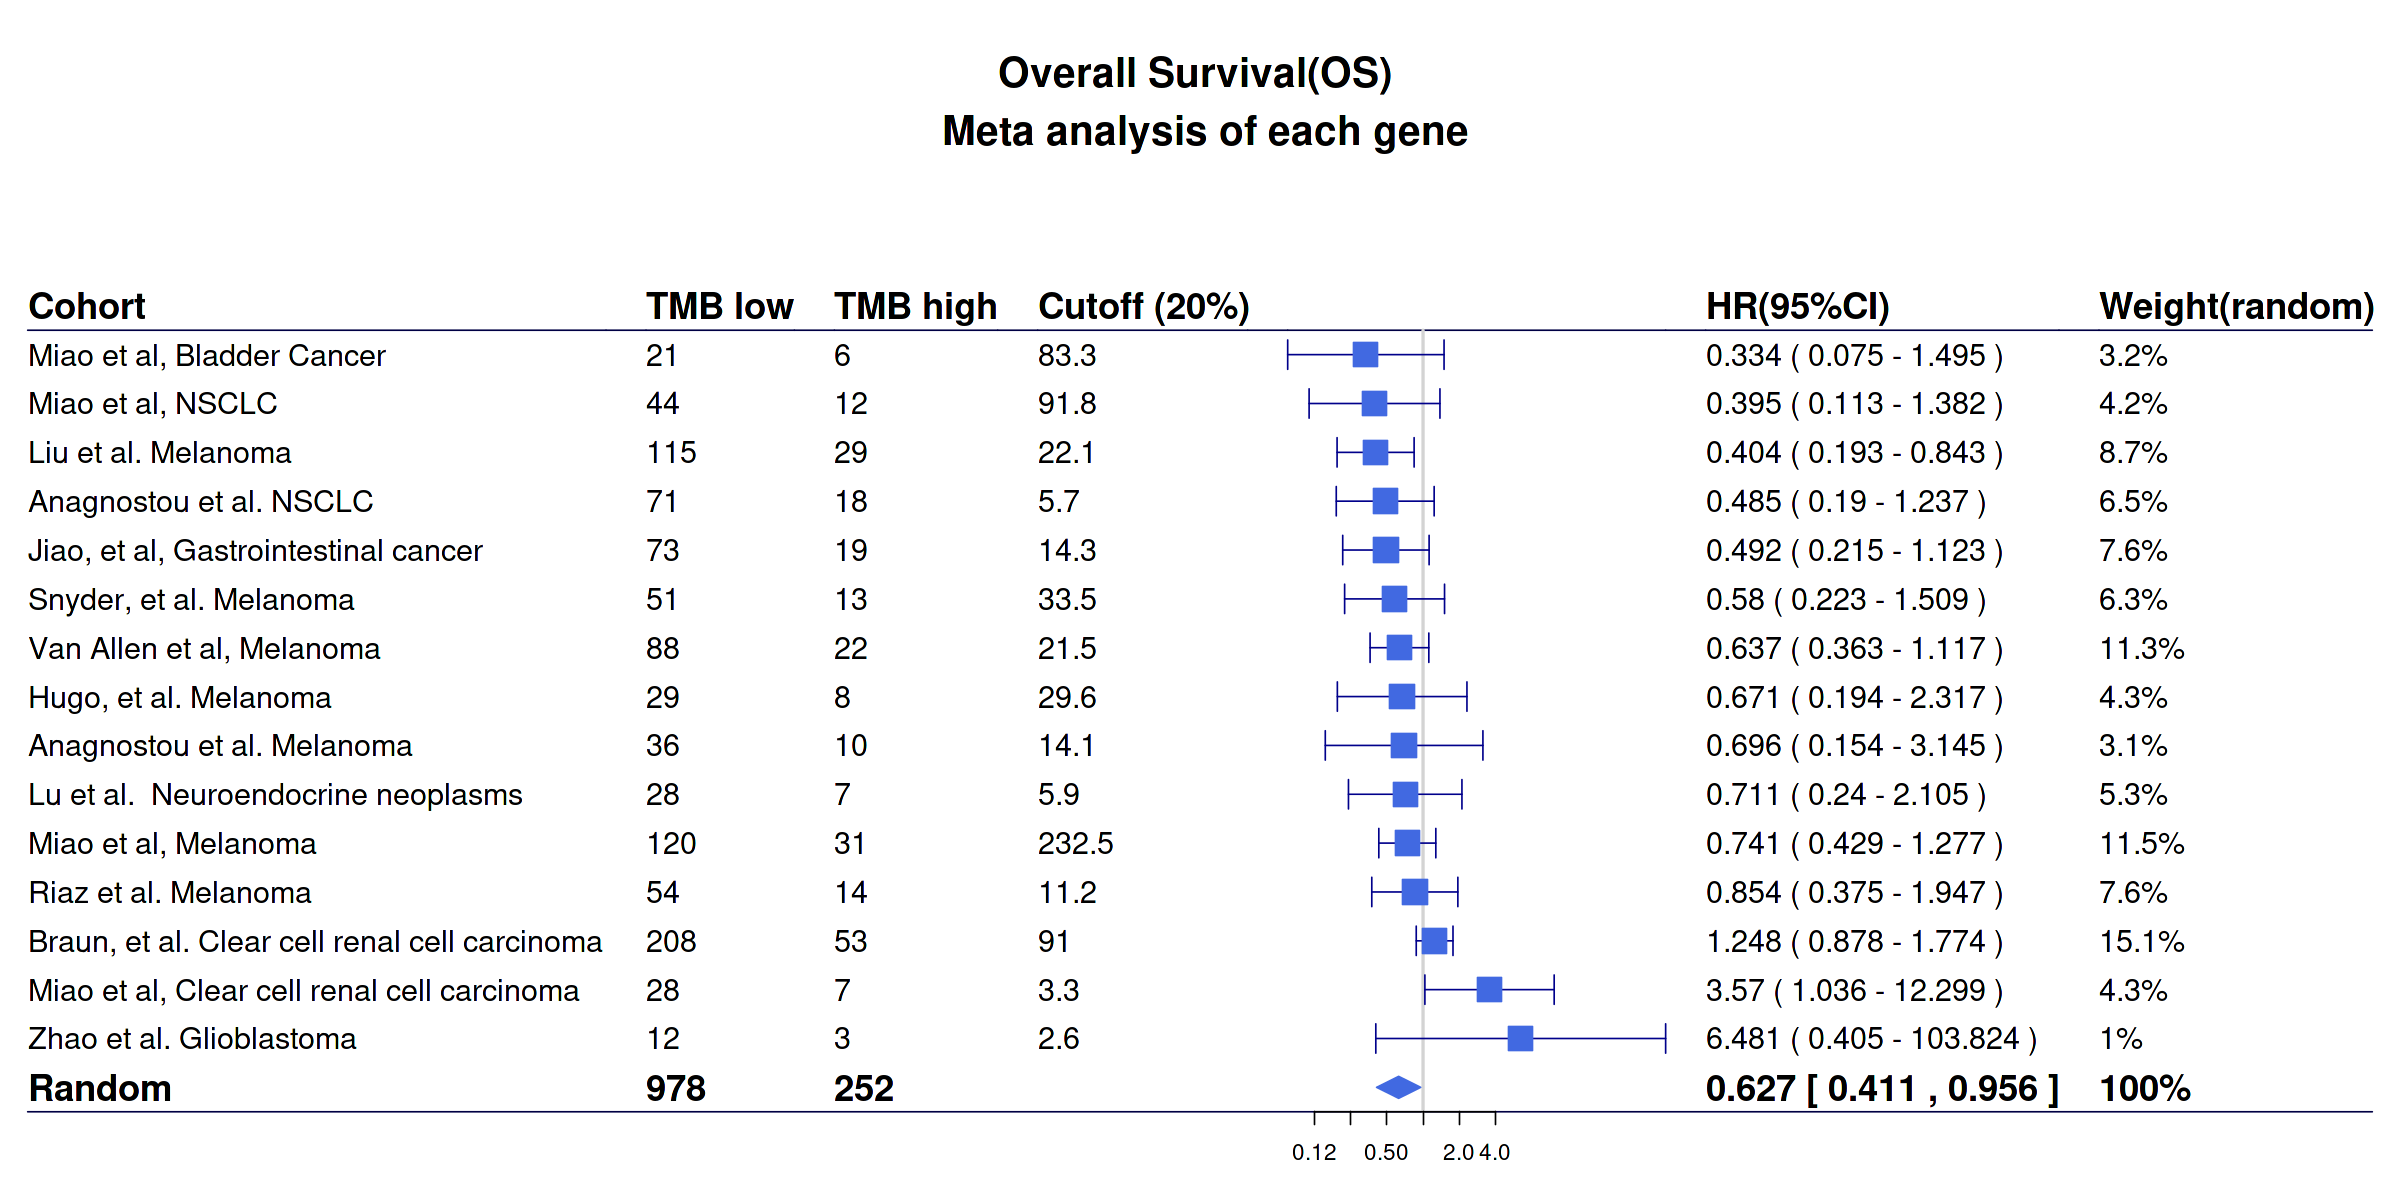

In [10]:
library(forestplot)
cohort = vector()
cutoff = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.2)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))
      
    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }

    
    
    
  }
}

ord = order(HR_mean)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"TMB low",low[ord],sum(low),sum(low)),
                  c(NA,"TMB high",high[ord],sum(high),sum(high)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (20%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [11]:
TMB_OS_tabletext.2 = TMB_OS_tabletext
TMB_OS_cochrane_from_rmeta.2 = TMB_OS_cochrane_from_rmeta

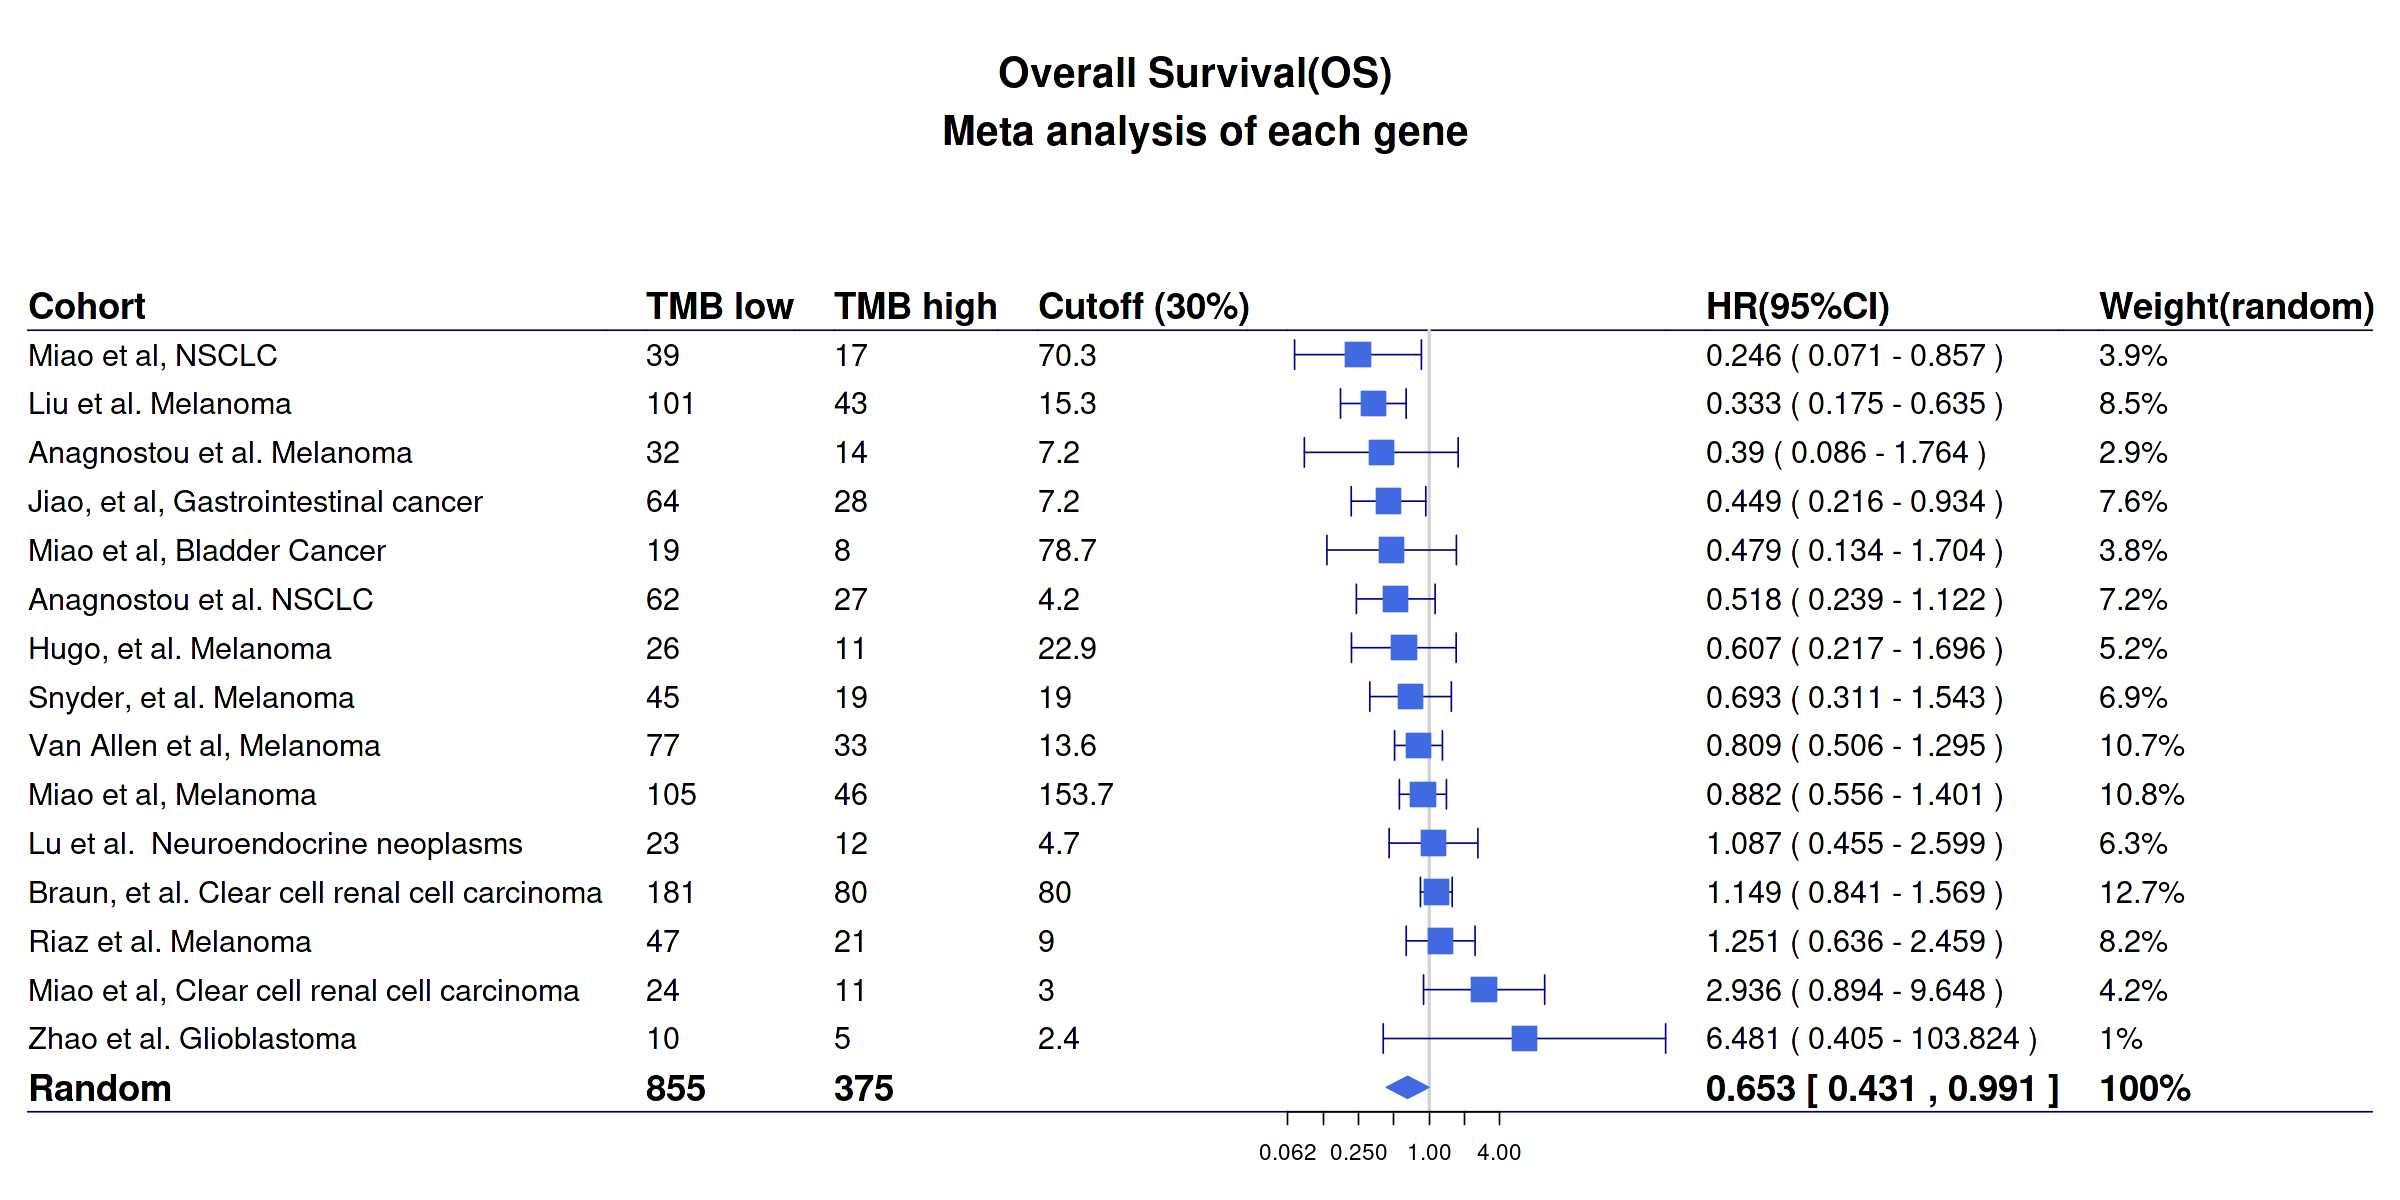

In [13]:
library(forestplot)
cohort = vector()
cutoff = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))
      
    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }

    
    
    
  }
}

ord = order(HR_mean)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"TMB low",low[ord],sum(low),sum(low)),
                  c(NA,"TMB high",high[ord],sum(high),sum(high)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (30%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [14]:
TMB_OS_tabletext.3 = TMB_OS_tabletext
TMB_OS_cochrane_from_rmeta.3 = TMB_OS_cochrane_from_rmeta

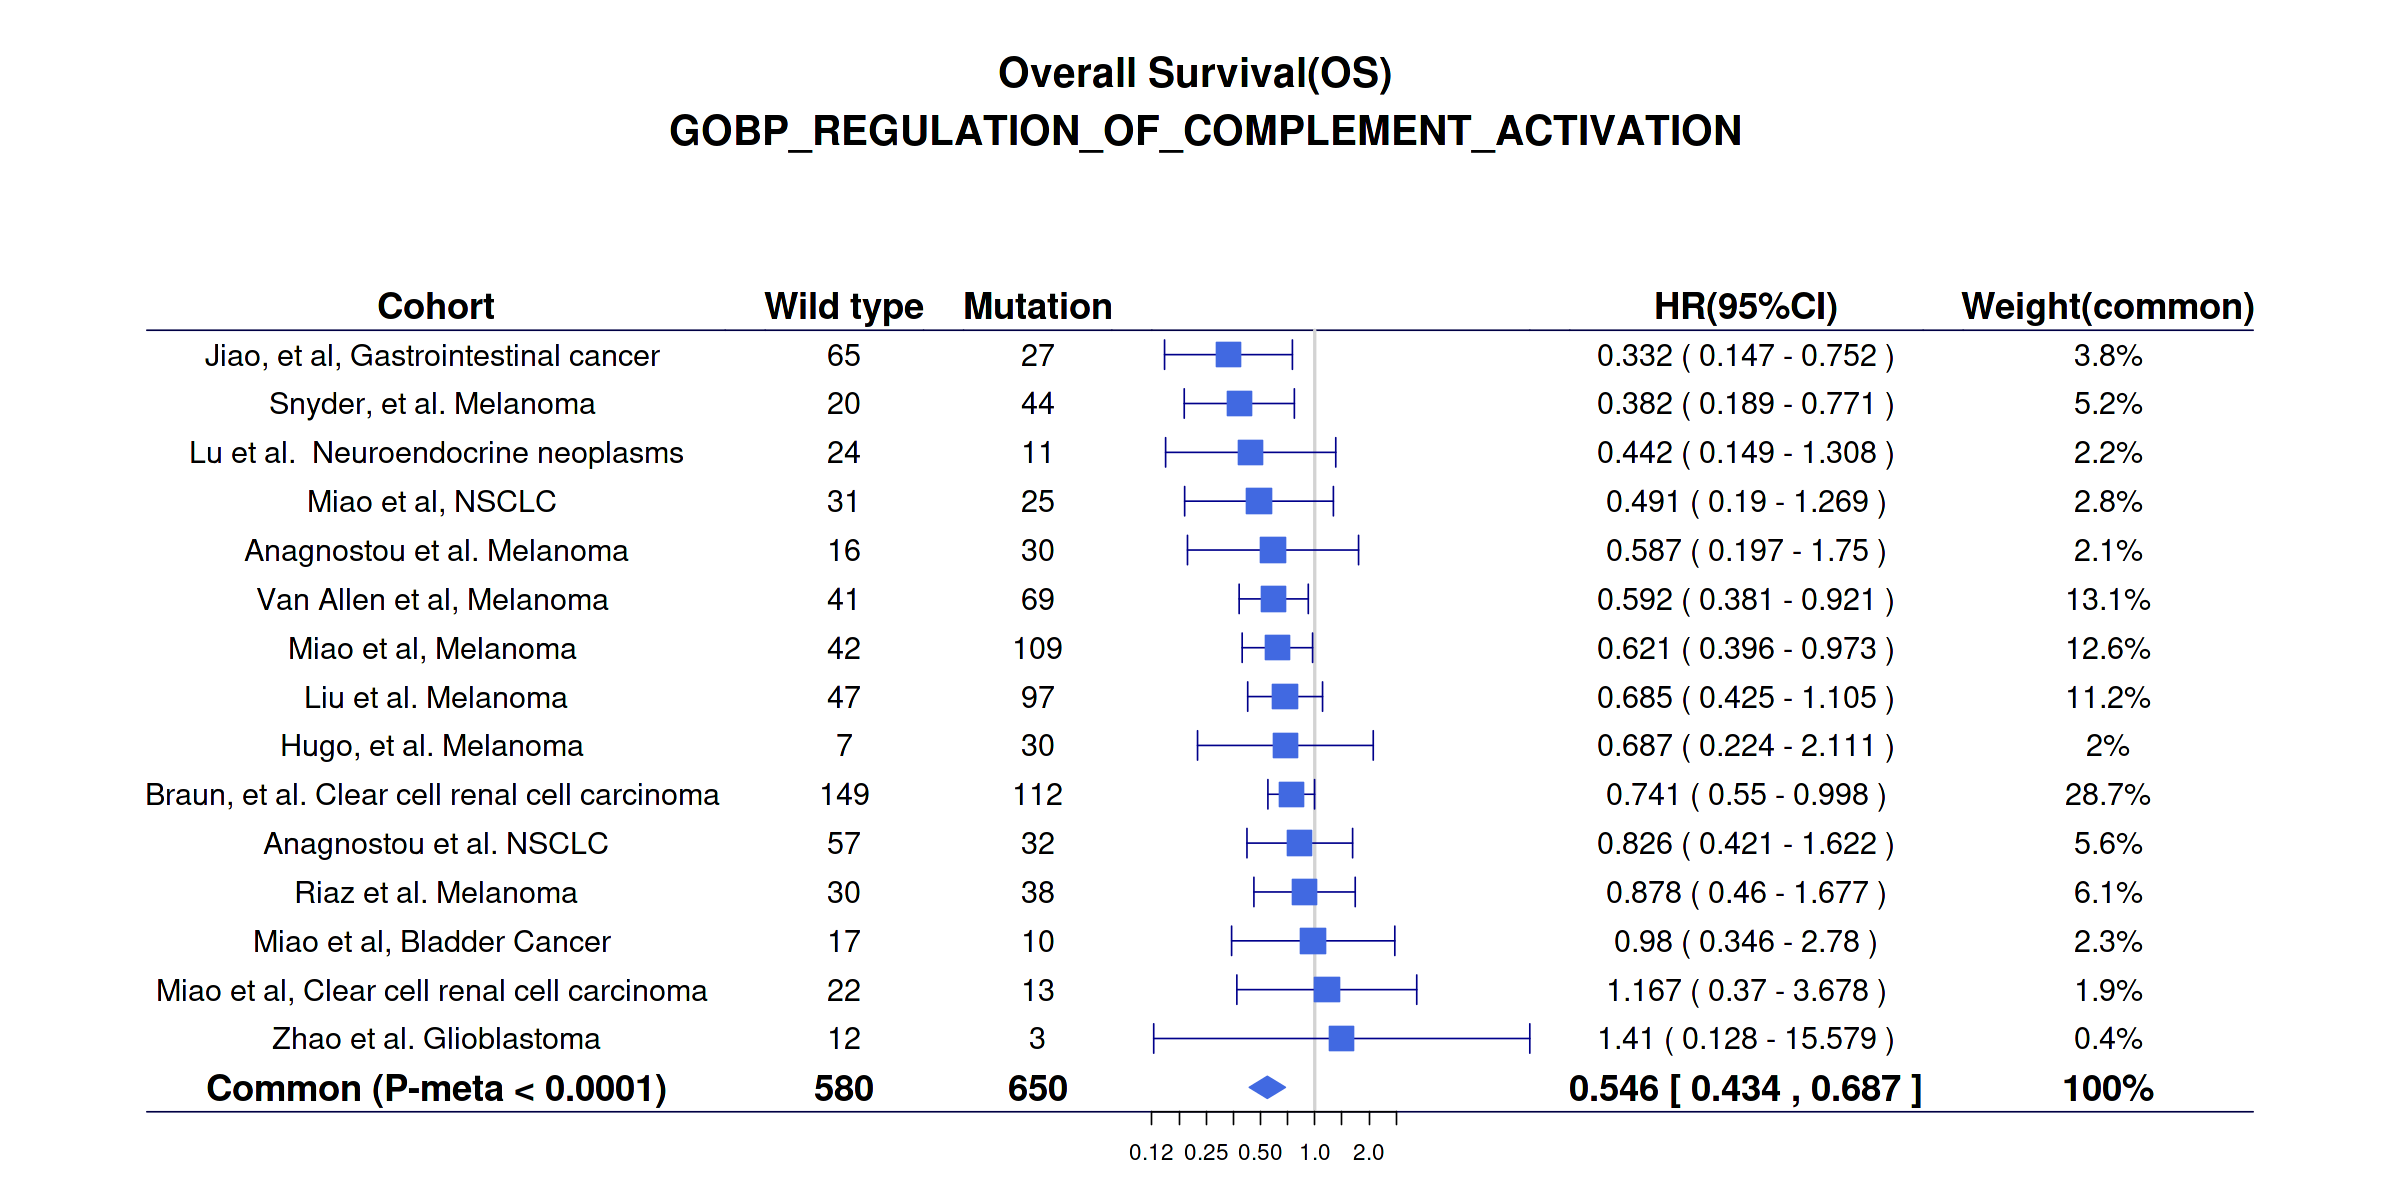

In [15]:
library(forestplot)
cohort = vector()
wildtype = vector()
mutation = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     wildtype = c(wildtype,length(tmp_cohort$wt))
#     mutation = c(mutation,length(tmp_cohort$mut))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        
        wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
        mutation = c(mutation,table(tmp_data$groups)["Mutation"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
        
        
        
        
    }
    

    
    
    
  }
}

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                  c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")
options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
                 lty.ci = 1,
                 ci.vertices.height = 0.3,
                 align="c",
                 graphwidth = unit(8,"cm"),
                 lwd.zero = gpar(lwd=2,lty=2),
                 txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 boxsize = 0.5,
                 graph.pos = 4,
                 title = paste("Overall Survival(OS)","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [16]:
cr = rbind(cochrane_from_rmeta2[nrow(cochrane_from_rmeta2),],
           TMB_OS_cochrane_from_rmeta.1,
           TMB_OS_cochrane_from_rmeta.2,
           TMB_OS_cochrane_from_rmeta.3
      )

In [17]:
if(round(k$pval.random,digits = 4)<0.001){
    tmp_p = "<0.001"
}else{
    tmp_p = round(k$pval.random,digits = 4)
}

In [18]:
tt = rbind(c(tabletext2[nrow(tabletext2),c(1,4)],tmp_p),
           TMB_OS_tabletext.1,
           TMB_OS_tabletext.2,
           TMB_OS_tabletext.3
     )

In [19]:
tt[,1] = c("GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION","TMB(cutoff=10%)","TMB(cutoff=20%)","TMB(cutoff=30%)")

In [20]:
total_tabletext = tt
total_cochrane_from_rmeta = cr

total_tabletext = rbind(c("Pathway","HR(95%CI)","P-meta"),total_tabletext)
total_cochrane_from_rmeta = rbind(c(NA,NA,NA),total_cochrane_from_rmeta)

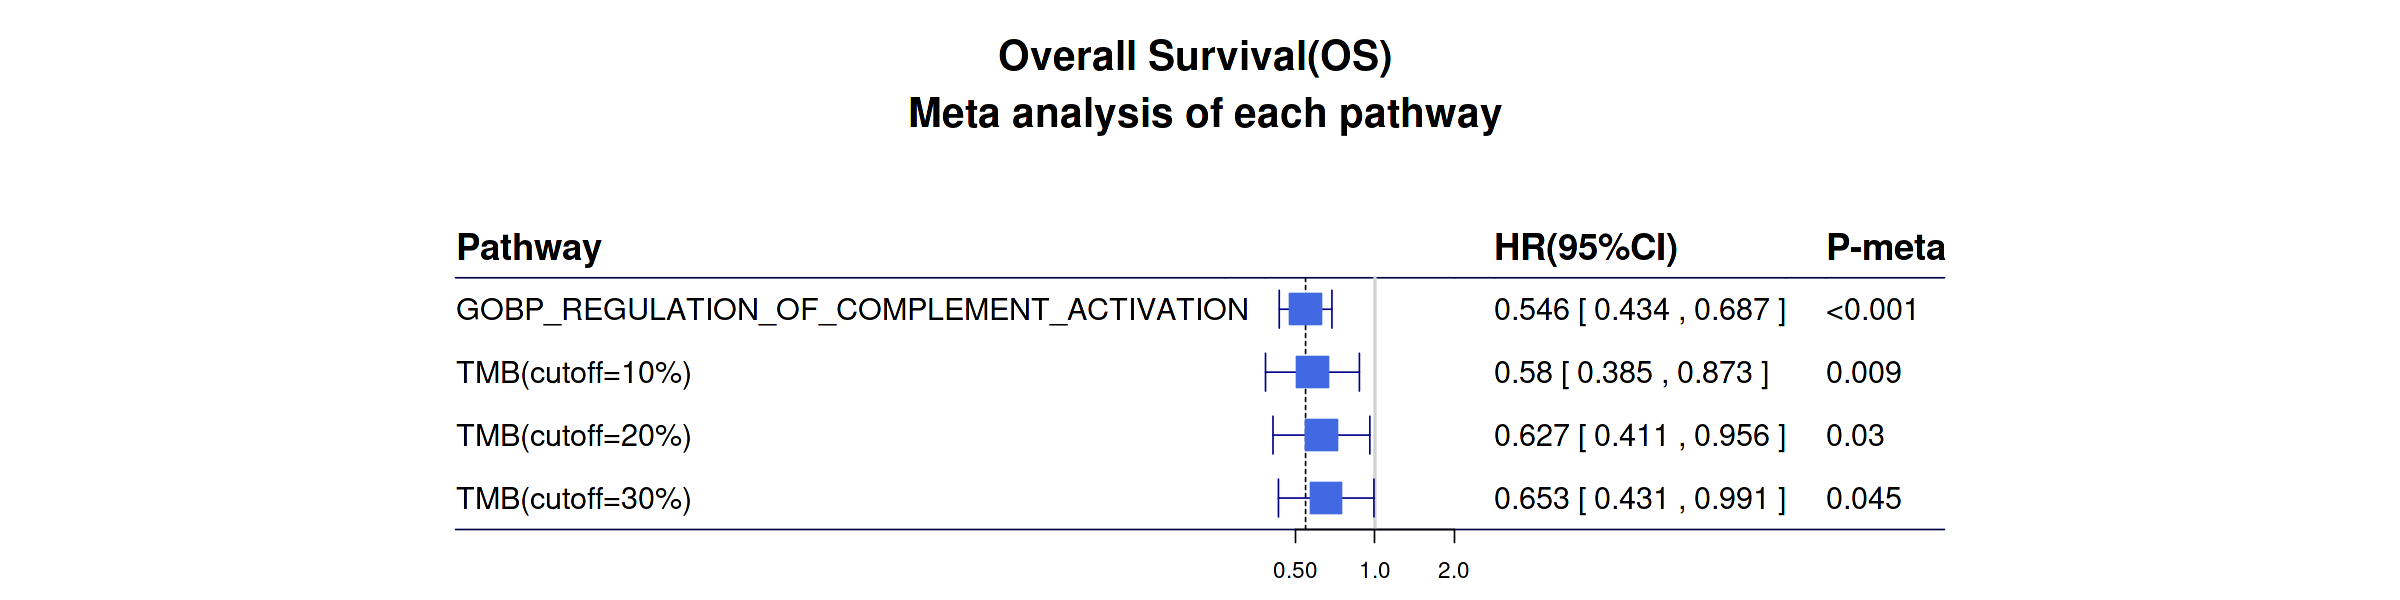

In [21]:
maxup = max(total_cochrane_from_rmeta$upper[!is.infinite(total_cochrane_from_rmeta$upper)],na.rm = T)
minlow = min(total_cochrane_from_rmeta$lower[total_cochrane_from_rmeta$lower != 0],na.rm = T)

    
options(repr.plot.height = 5, repr.plot.width = 20)

tmp_list = list()
tmp_list[["2"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(total_cochrane_from_rmeta) + 1)]] = gpar(col = "#000044")


p = total_cochrane_from_rmeta %>% 
       forestplot(labeltext = total_tabletext, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(4,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
                     grid = structure(c(cochrane_from_rmeta2[nrow(cochrane_from_rmeta2),1]), 
                            gp = gpar(lwd = 1,lty = 2, col = "black")),
                     boxsize = 0.5,
                     graph.pos = 2,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each pathway"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                     is.summary = c(rep(TRUE, 1), rep(FALSE, nrow(total_cochrane_from_rmeta)-1)),
                     xlog = TRUE, 
                     hrzl_lines = tmp_list,
                     vertices = TRUE,
                     col = fpColors(box = "royalblue",
                                    line = "darkblue",
                                    summary = "royalblue")
                     )
p

### RECIST/RESPONSE

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

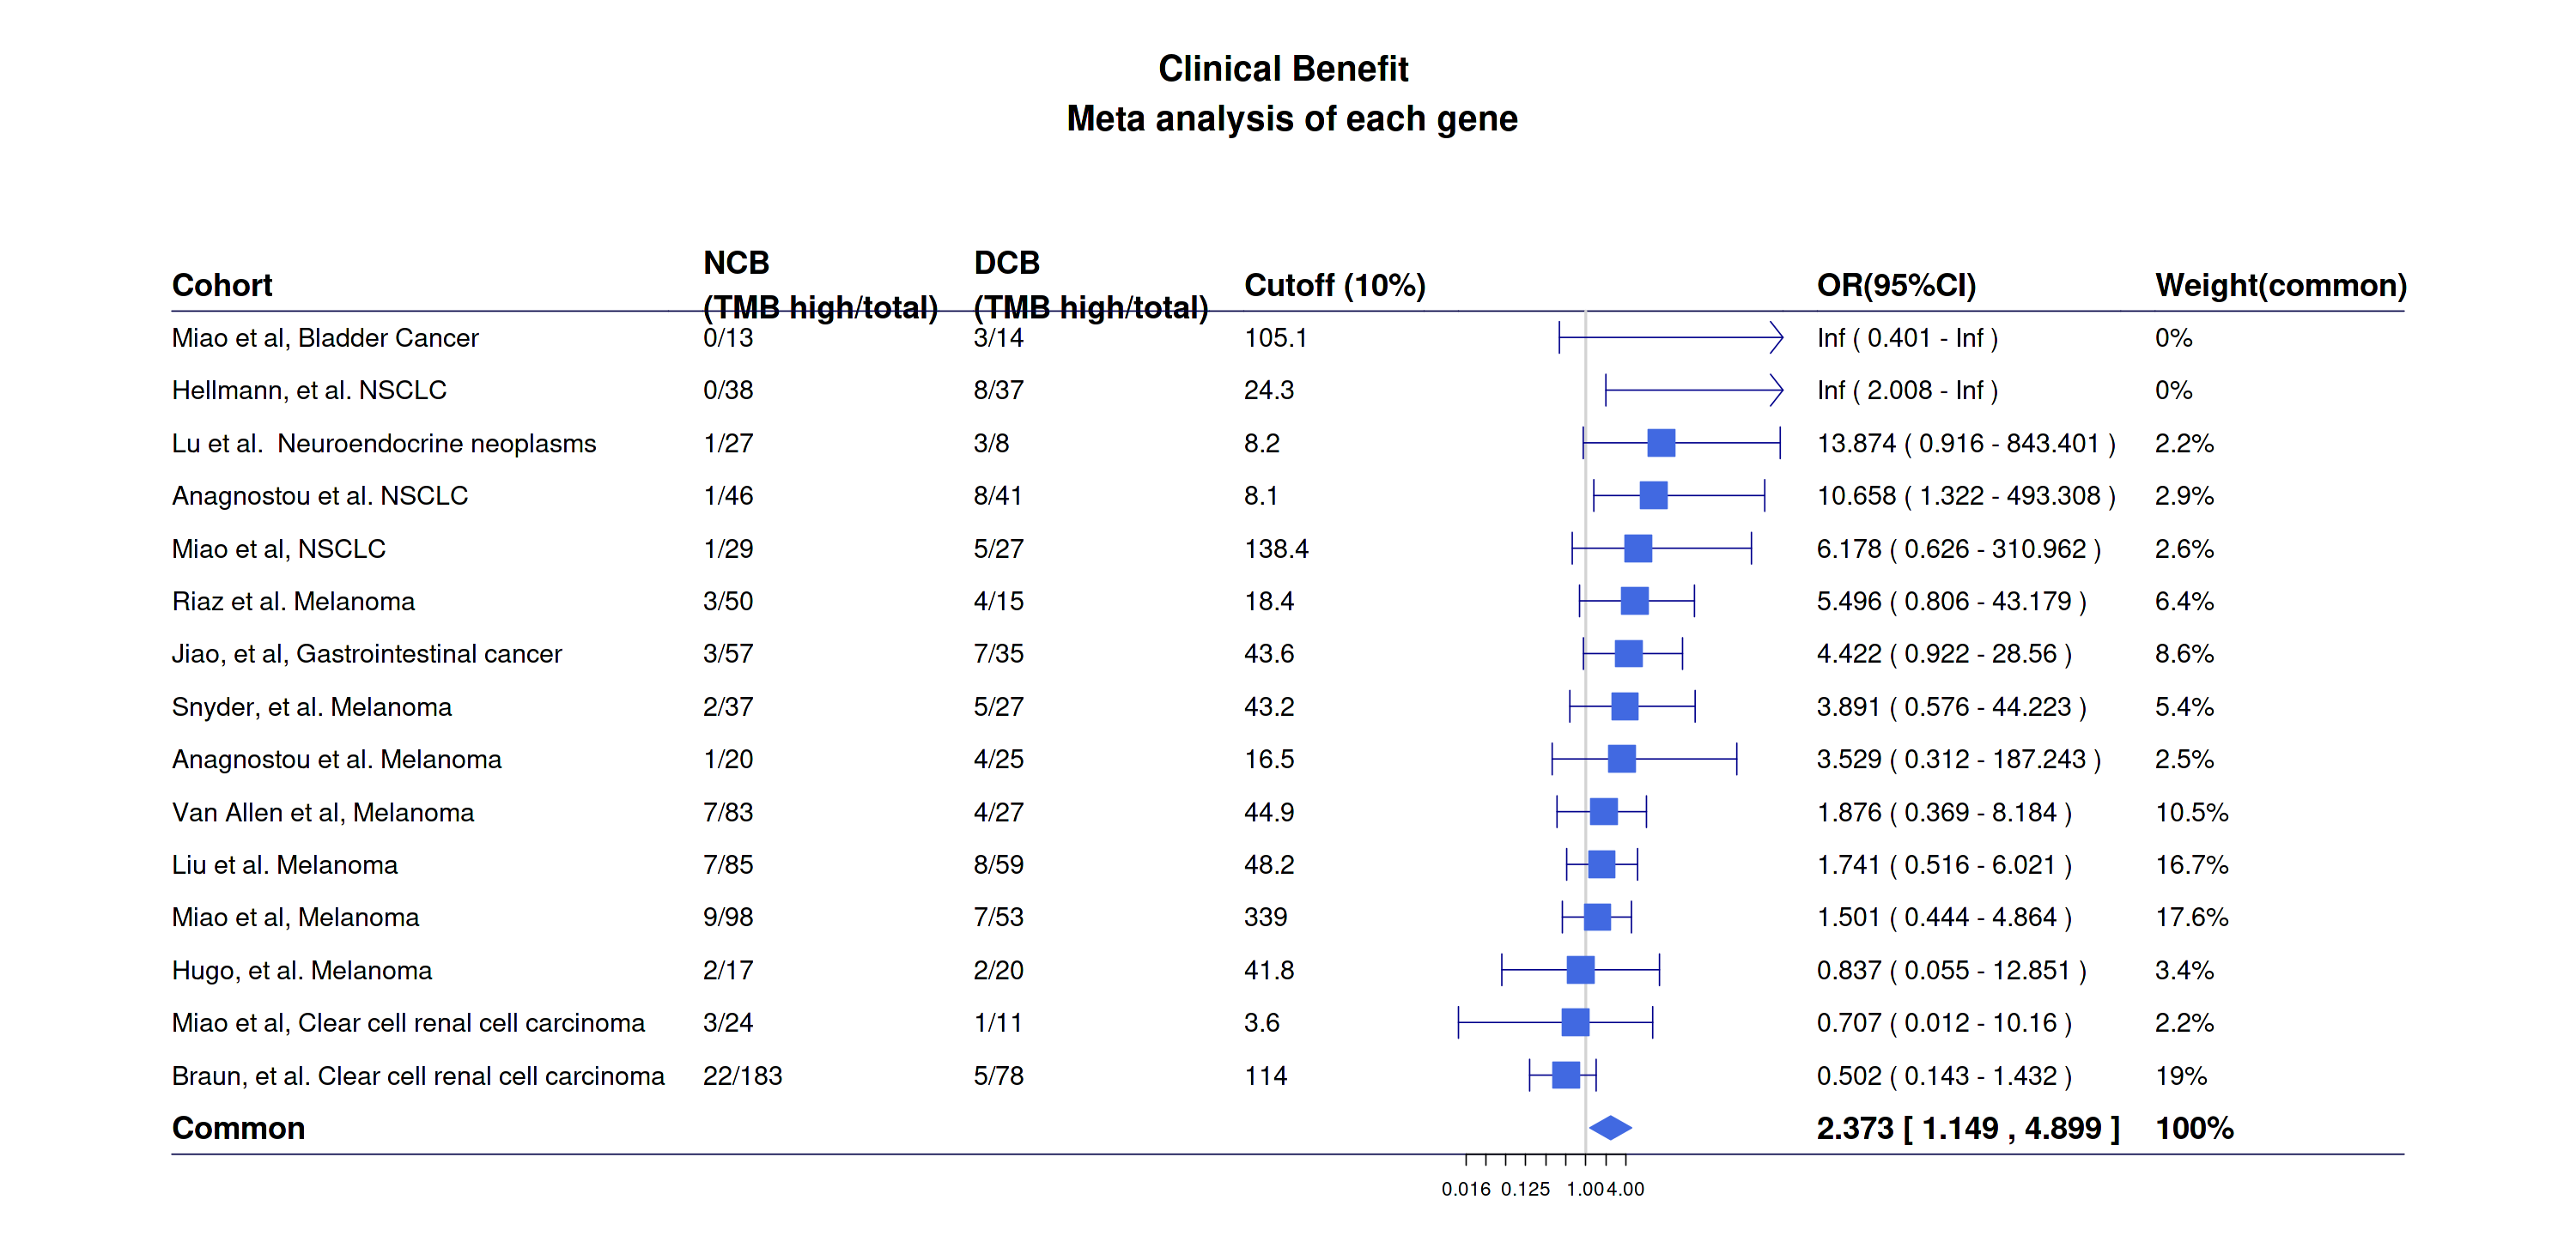

In [41]:
library(forestplot)
cohort = vector()
cutoff = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.1)  
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["TMB high","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["TMB high","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3))
    
    }
    
  }else if(length(tmp_cohort$high) != 0 & length(tmp_cohort$low) != 0 & ("RECIST" %in% colnames(All[[i]]))){
          
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["TMB high","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["TMB high","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        }
  }
}

ord = order(OR_mean,decreasing = T)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)

tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(TMB high/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(TMB high/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)

)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (10%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 12, repr.plot.width = 25)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [42]:
TMB_DR_tabletext.1 = TMB_DR_tabletext
TMB_DR_cochrane_from_rmeta.1 = TMB_DR_cochrane_from_rmeta

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

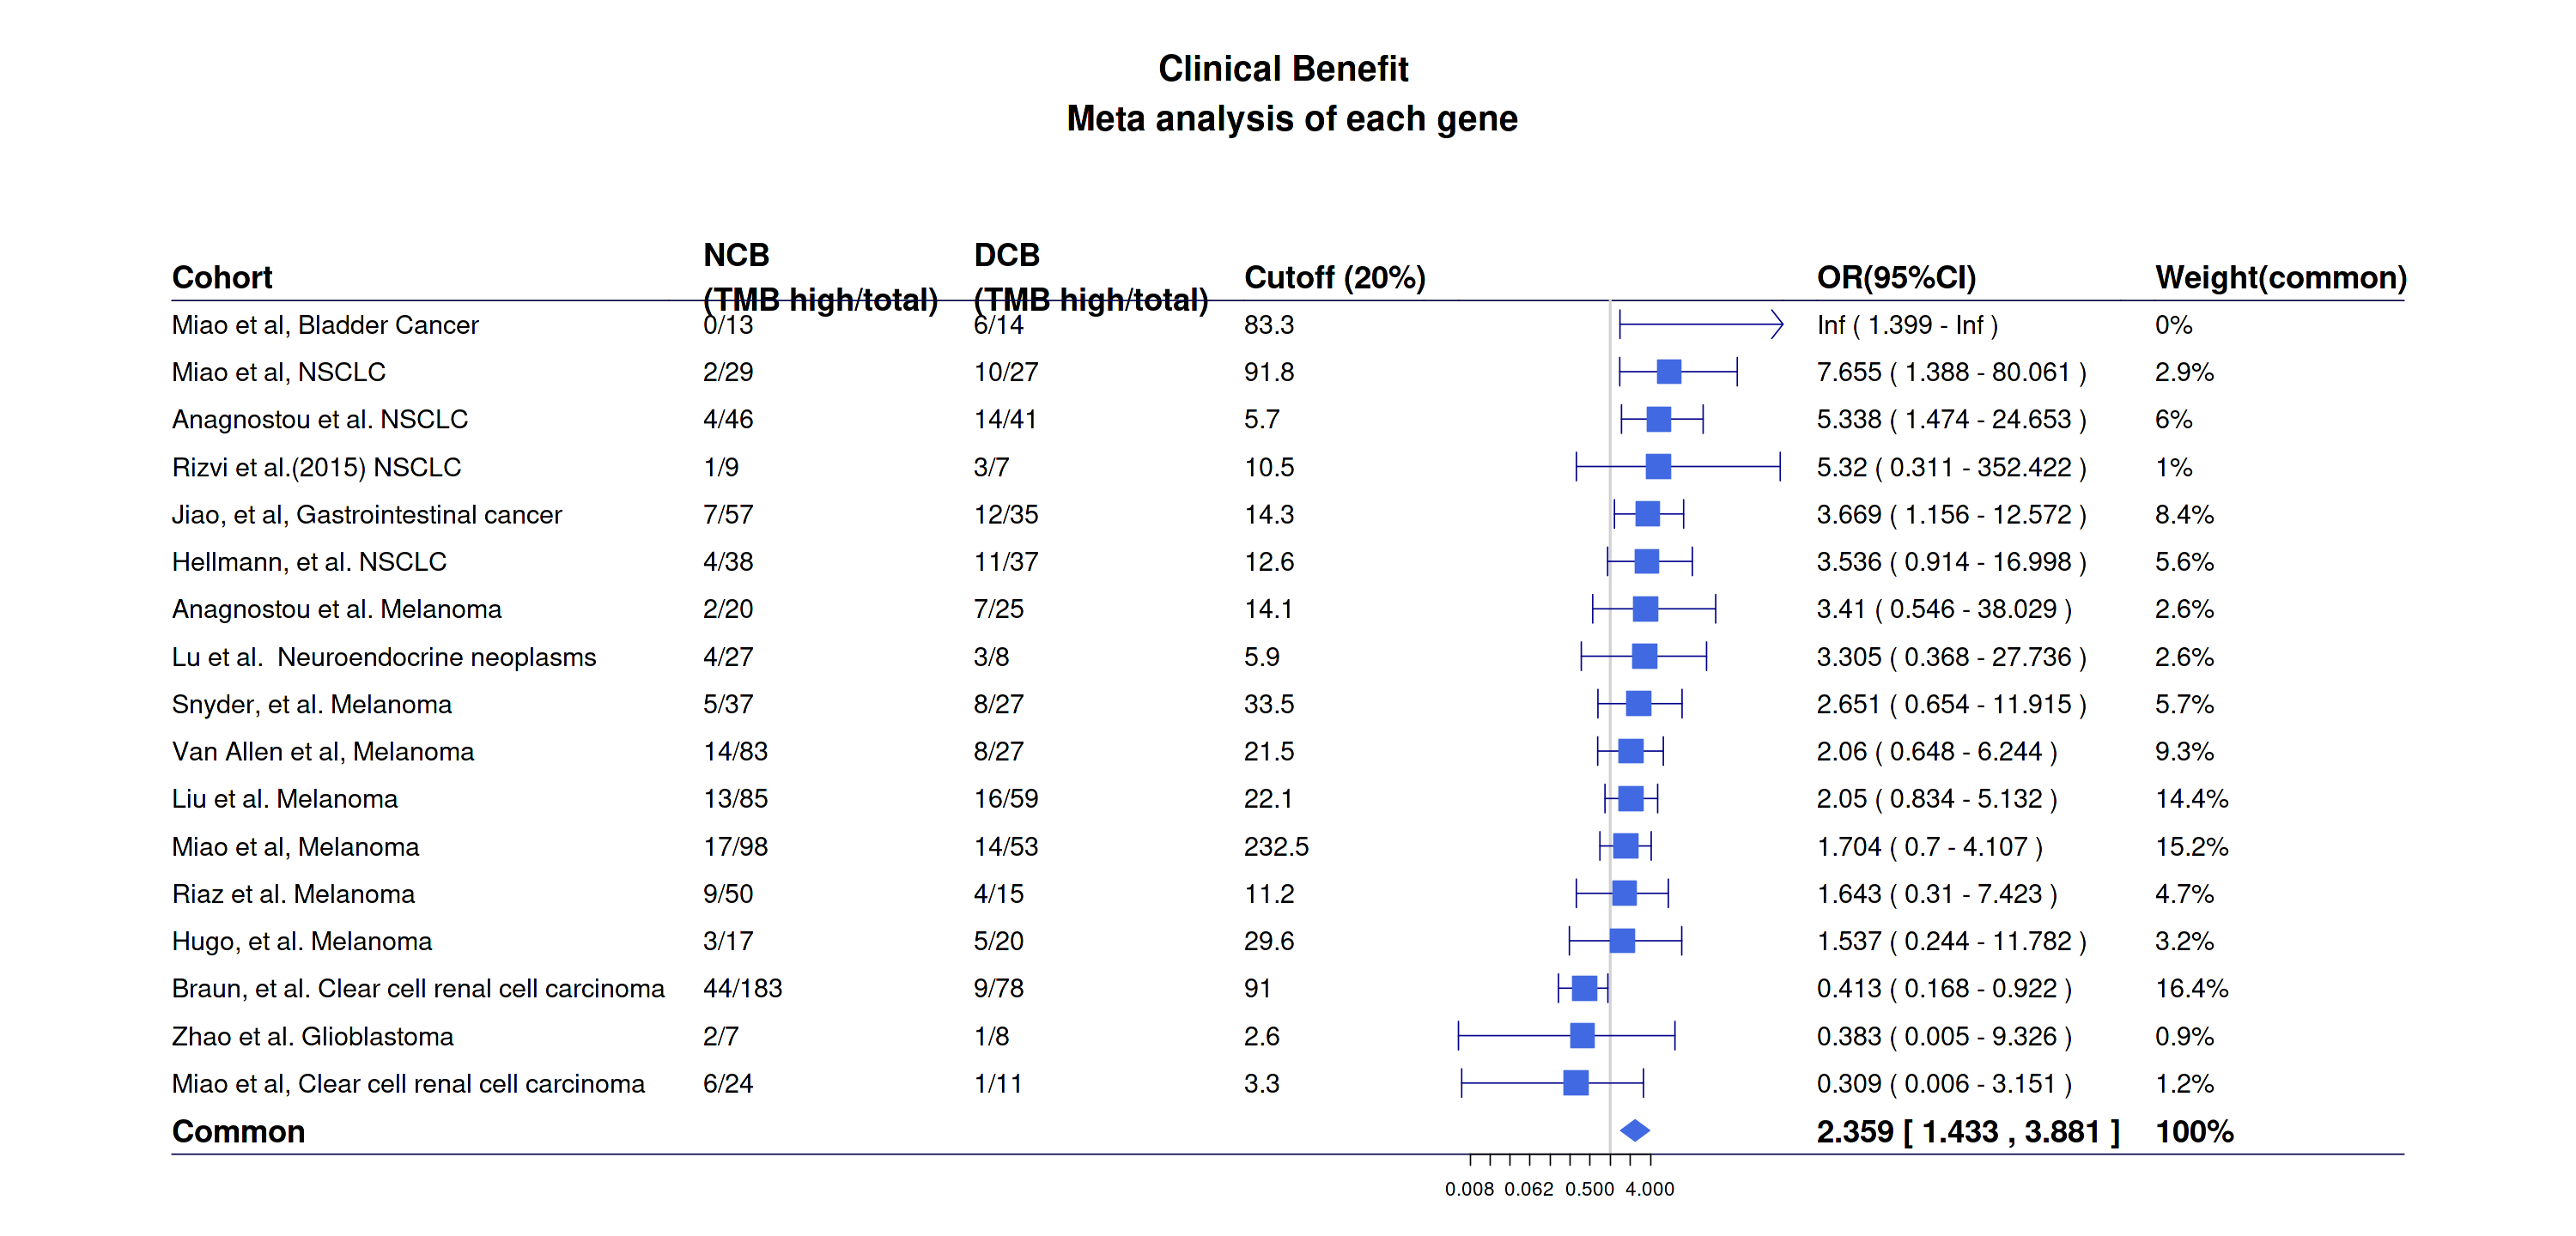

In [43]:
library(forestplot)
cohort = vector()
cutoff = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.2)  
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["TMB high","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["TMB high","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3))
    
    }
    
  }else if(length(tmp_cohort$high) != 0 & length(tmp_cohort$low) != 0 & ("RECIST" %in% colnames(All[[i]]))){
          
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["TMB high","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["TMB high","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        }
  }
}

ord = order(OR_mean,decreasing = T)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)

tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(TMB high/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(TMB high/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)

)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (20%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 12, repr.plot.width = 25)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [44]:
TMB_DR_tabletext.2 = TMB_DR_tabletext
TMB_DR_cochrane_from_rmeta.2 = TMB_DR_cochrane_from_rmeta

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

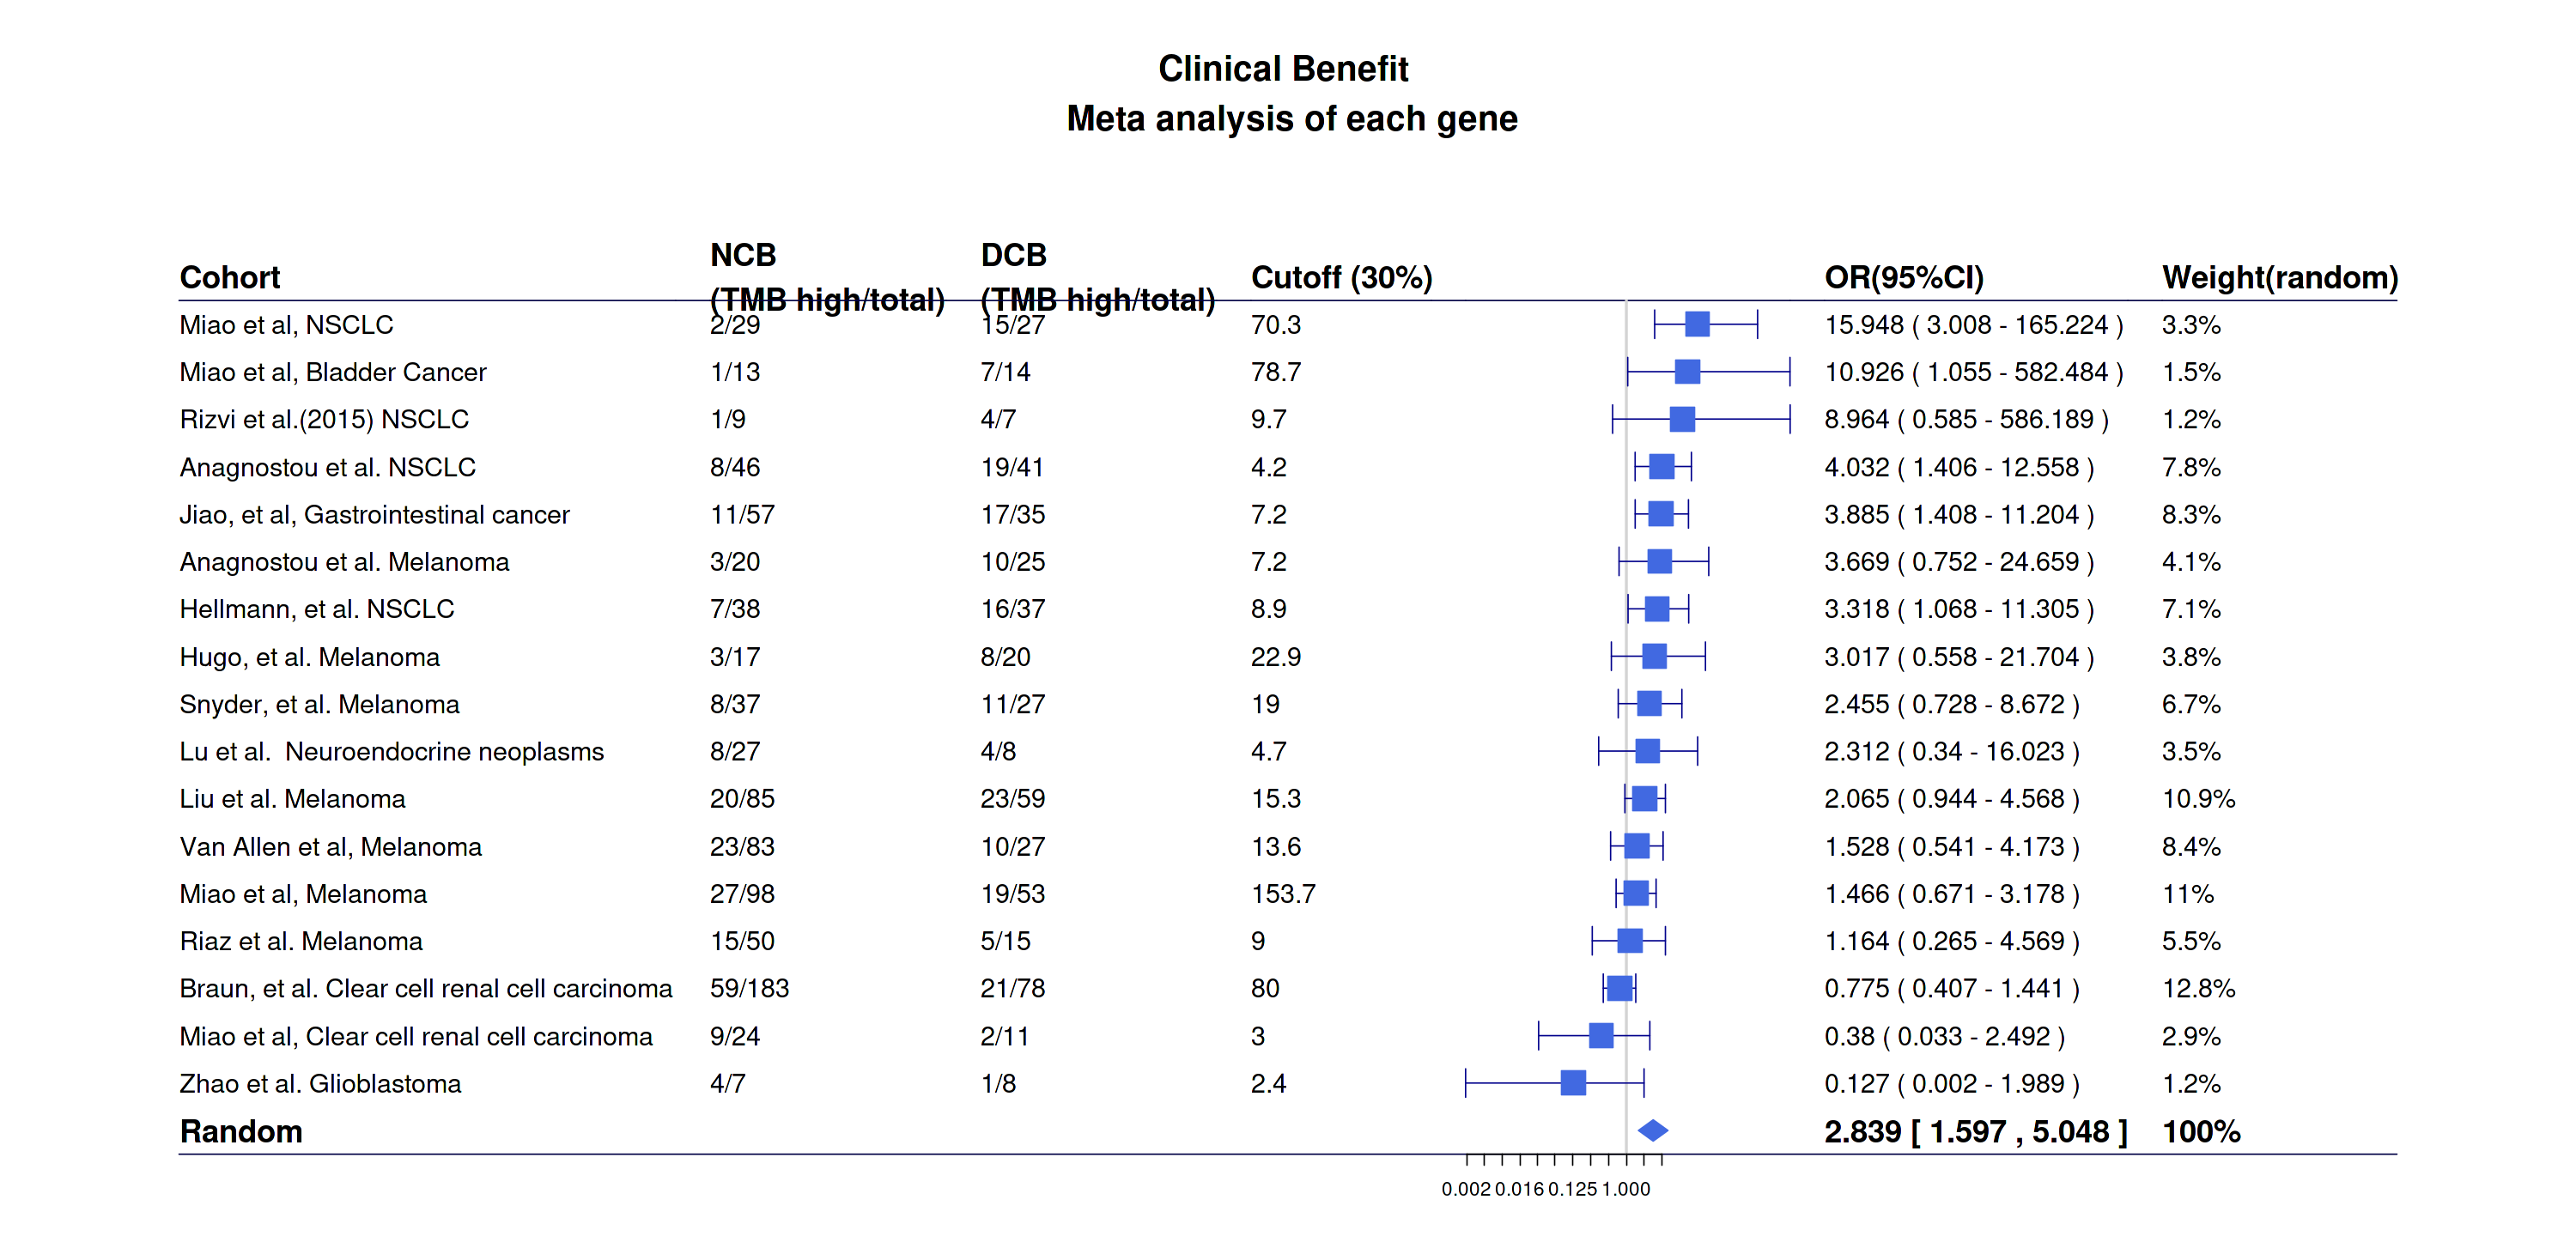

In [45]:
library(forestplot)
cohort = vector()
cutoff = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)  
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["TMB high","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["TMB high","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3))
    
    }
    
  }else if(length(tmp_cohort$high) != 0 & length(tmp_cohort$low) != 0 & ("RECIST" %in% colnames(All[[i]]))){
          
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        cohort = c(cohort,dataset_name[i])
        cutoff = c(cutoff,tmp_cohort$cutoff)
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["TMB high","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["TMB high","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        }
  }
}

ord = order(OR_mean,decreasing = T)
cutoff = cutoff[ord]
cutoff = round(cutoff,digits = 1)

tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(TMB high/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(TMB high/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)

)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

tabletext2 = cbind(tabletext2[,1:3],c(NA,"Cutoff (30%)",cutoff,NA),tabletext2[,4:5])

options(repr.plot.height = 12, repr.plot.width = 25)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 5,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [46]:
TMB_DR_tabletext.3 = TMB_DR_tabletext
TMB_DR_cochrane_from_rmeta.3 = TMB_DR_cochrane_from_rmeta

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

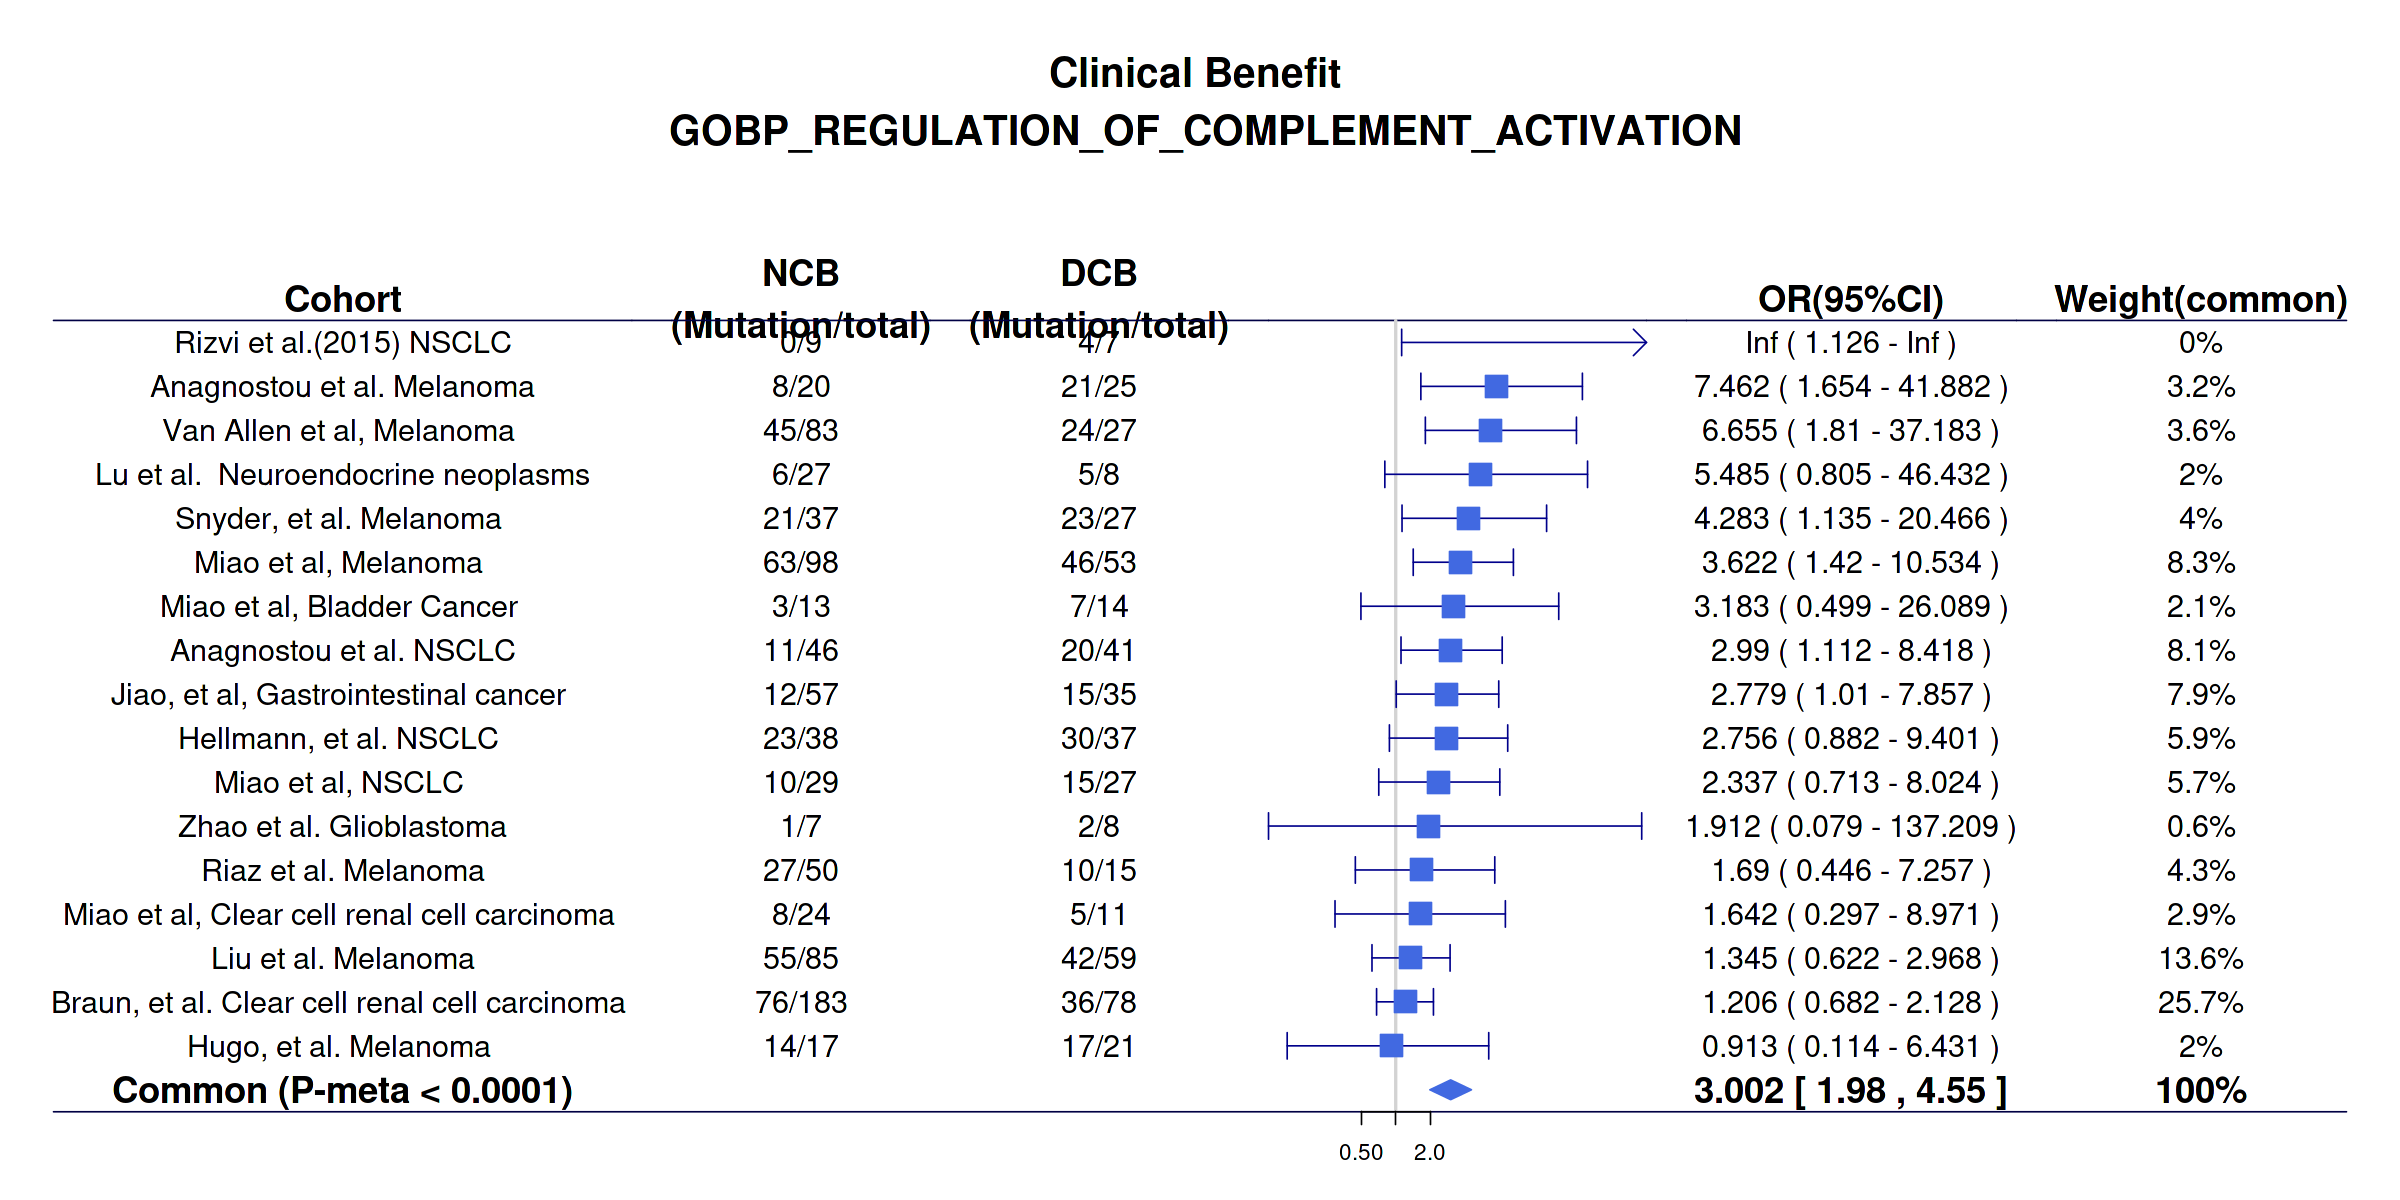

In [47]:
library(forestplot)
cohort = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["Mutation","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["Mutation","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3)) 
        
        
    }

    
    
    
  }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]]))){
      
    
    
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["Mutation","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["Mutation","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        
        
    }

      
  }
}

ord = order(OR_mean,decreasing = T)
tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(Mutation/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(Mutation/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

  tmp_list = list()
  tmp_list[["3"]] = gpar(col = "#000044")
  tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

  options(repr.plot.height = 10, repr.plot.width = 20)
  p = cochrane_from_rmeta2 %>%
    forestplot(labeltext = tabletext2,clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
               
                lty.ci = 1,
                ci.vertices.height = 0.3,
                align="c",
                graphwidth = unit(8,"cm"),
                lwd.zero = gpar(lwd=2,lty=2),
               txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
               boxsize = 0.5,
               graph.pos = 4,
               title = paste("Clinical Benefit","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
               is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
               xlog = TRUE,
               hrzl_lines = tmp_list,
               vertices = TRUE,
               col = fpColors(box = "royalblue",
                              line = "darkblue",
                              summary = "royalblue")
    )
  print(p)

In [48]:
cr = rbind(cochrane_from_rmeta2[nrow(cochrane_from_rmeta2),],
           TMB_DR_cochrane_from_rmeta.1,
           TMB_DR_cochrane_from_rmeta.2,
           TMB_DR_cochrane_from_rmeta.3
      )

In [49]:
if(round(k$pval.random,digits = 4)<0.001){
    tmp_p = "<0.001"
}else{
    tmp_p = round(k$pval.random,digits = 4)
}

In [50]:
tt = rbind(c(tabletext2[nrow(tabletext2),c(1,4)],tmp_p),
           TMB_DR_tabletext.1,
           TMB_DR_tabletext.2,
           TMB_DR_tabletext.3
     )

In [51]:
tt[,1] = c("GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION","TMB(cutoff=10%)","TMB(cutoff=20%)","TMB(cutoff=30%)")

In [52]:
total_tabletext = tt
total_cochrane_from_rmeta = cr

total_tabletext = rbind(c("Pathway","HR(95%CI)","P-meta"),total_tabletext)
total_cochrane_from_rmeta = rbind(c(NA,NA,NA),total_cochrane_from_rmeta)

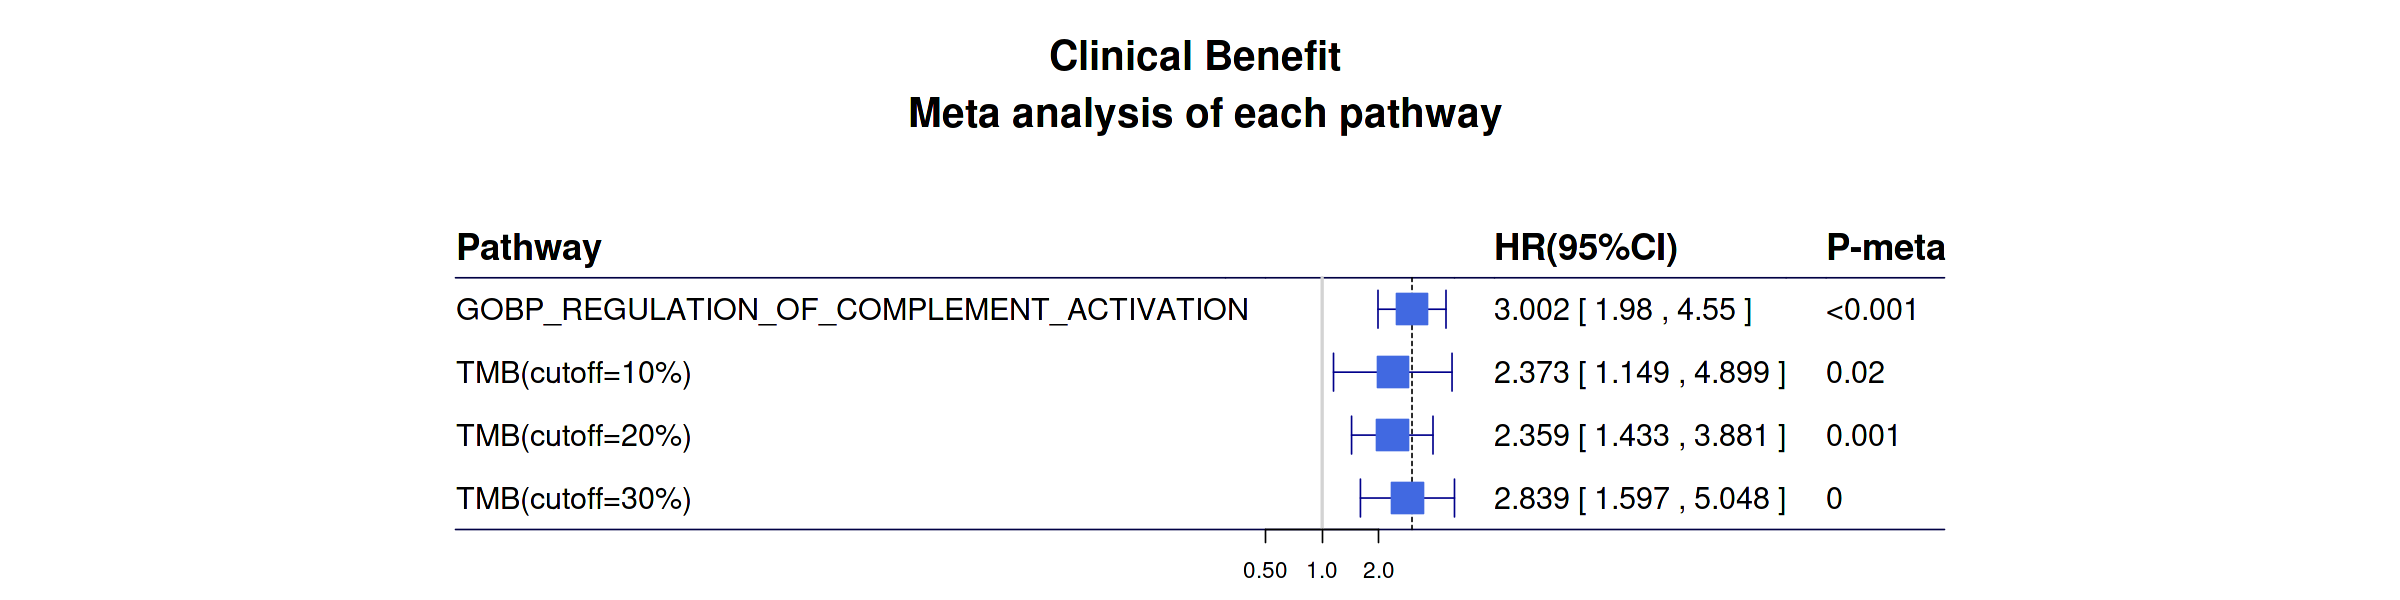

In [54]:
maxup = max(total_cochrane_from_rmeta$upper[!is.infinite(total_cochrane_from_rmeta$upper)],na.rm = T)
minlow = min(total_cochrane_from_rmeta$lower[total_cochrane_from_rmeta$lower != 0],na.rm = T)

    
options(repr.plot.height = 5, repr.plot.width = 20)

tmp_list = list()
tmp_list[["2"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(total_cochrane_from_rmeta) + 1)]] = gpar(col = "#000044")


p = total_cochrane_from_rmeta %>% 
       forestplot(labeltext = total_tabletext, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(4,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
                     grid = structure(c(cochrane_from_rmeta2[nrow(cochrane_from_rmeta2),1]), 
                            gp = gpar(lwd = 1,lty = 2, col = "black")),
                     boxsize = 0.5,
                     graph.pos = 2,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each pathway"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                     is.summary = c(rep(TRUE, 1), rep(FALSE, nrow(total_cochrane_from_rmeta)-1)),
                     xlog = TRUE, 
                     hrzl_lines = tmp_list,
                     vertices = TRUE,
                     col = fpColors(box = "royalblue",
                                    line = "darkblue",
                                    summary = "royalblue")
                     )
p